Objectives

Business Question  - The client is interested in determining whether a particular leaf is infected or not.

Inputs

split_data/train
split_data/test
split_data/validation
created image embeddings

Outputs



In [6]:
%pip install keras scipy



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Import packages

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

Set Directory

In [8]:
cwd= os.getcwd()

In [9]:
os.chdir('/workspace/project5-mildrew')
print("You set a new current directory")

You set a new current directory


In [10]:
work_dir = os.getcwd()
work_dir

'/workspace/project5-mildrew'

Set Input Directories

In [11]:
my_data_dir = 'split_data'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Reset Output Directory

In [12]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set the label to train images

In [13]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


Get Image Shape from the previous data visualisation output

In [14]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

Plot the number of images in the train, validation and test sections

* train - healthy: 1261 images
* train - powdery_mildew: 1262 images
* validation - healthy: 420 images
* validation - powdery_mildew: 420 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


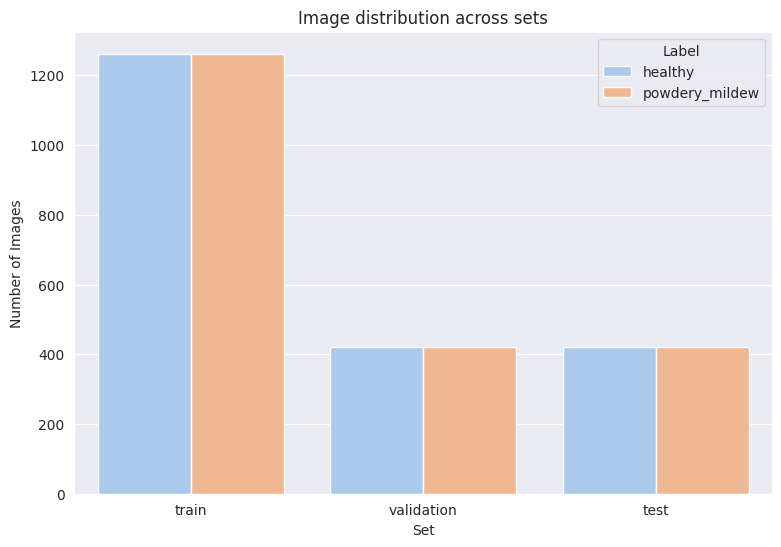

In [15]:
data = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = int(len(os.listdir(os.path.join(my_data_dir, folder, label))))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        print(f"* {folder} - {label}: {frequency} images")

# Create dataframe
df_freq = pd.DataFrame(data)

# Plot number of images in each section
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='pastel')
plt.title('Image distribution across sets')
plt.ylabel('Number of Images')
plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()



Image Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-08 18:07:52.015181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 18:07:52.058012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 18:07:52.058964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 18:07:53.102290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Set Augmentation Parameters

In [17]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Apply augmentations on training image set

In [18]:
batch_size = 10
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=(100, 100),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2523 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on validation image set

In [19]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=(100, 100),
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 840 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on test image set

In [20]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=(100, 100),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Images (Validation & Test Set)

(10, 100, 100, 3)


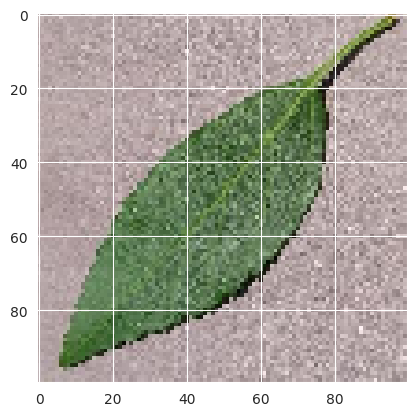

(10, 100, 100, 3)


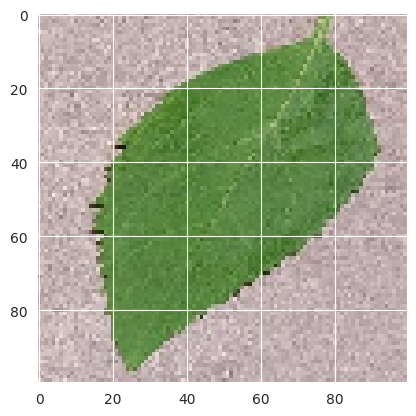

(10, 100, 100, 3)


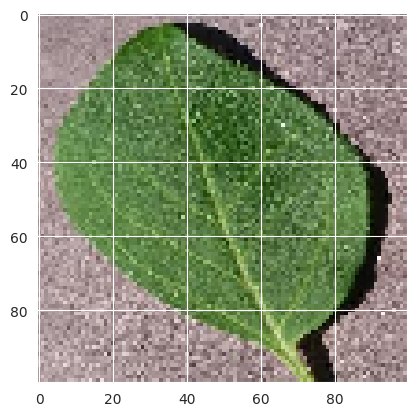

In [21]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(10, 100, 100, 3)


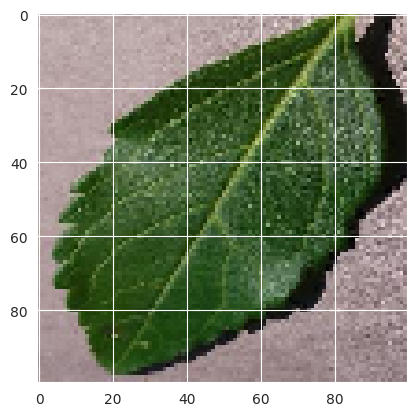

(10, 100, 100, 3)


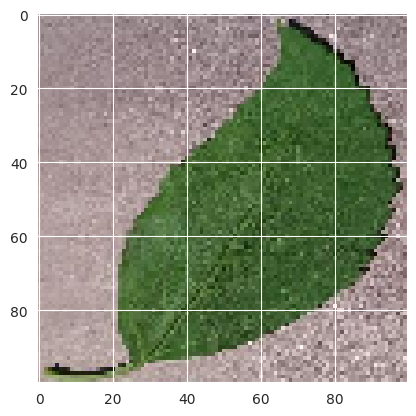

(10, 100, 100, 3)


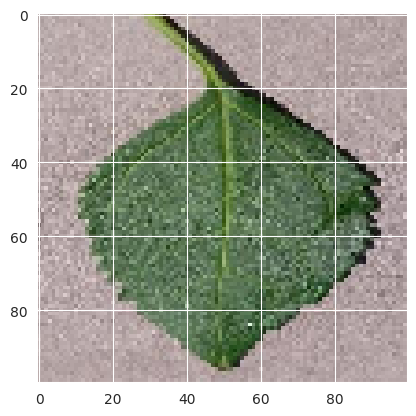

In [22]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class indices

In [23]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

Machine Learning Model

Import packages

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

ML model

In [25]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100, 100, 3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

summary

In [26]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

Early Stop

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=4)

fit model

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=15,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/15


252/252 [==============================] - 17s 66ms/step - loss: 0.2914 - accuracy: 0.8627 - val_loss: 0.0421 - val_accuracy: 0.9893
Epoch 2/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0757 - accuracy: 0.9753 - val_loss: 0.0229 - val_accuracy: 0.9940
Epoch 3/15
252/252 [==============================] - 24s 96ms/step - loss: 0.0334 - accuracy: 0.9901 - val_loss: 0.0053 - val_accuracy: 0.9976
Epoch 4/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0459 - accuracy: 0.9841 - val_loss: 9.3068e-04 - val_accuracy: 1.0000
Epoch 5/15
252/252 [==============================] - 16s 64ms/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 0.0144 - val_accuracy: 0.9976
Epoch 6/15
252/252 [==============================] - 16s 64ms/step - loss: 0.0270 - accuracy: 0.9924 - val_loss: 0.0068 - val_accuracy: 0.9988
Epoch 7/15
252/252 [==============================] - 17s 67ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0070 - val_accuracy: 0.9988

In [29]:
model.save('outputs/v1/mildew_detector_model100.h5')

/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


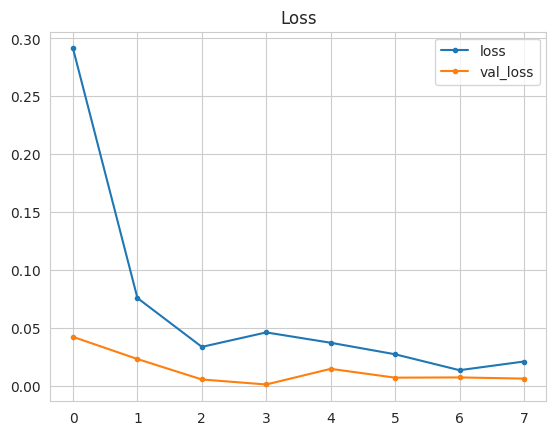

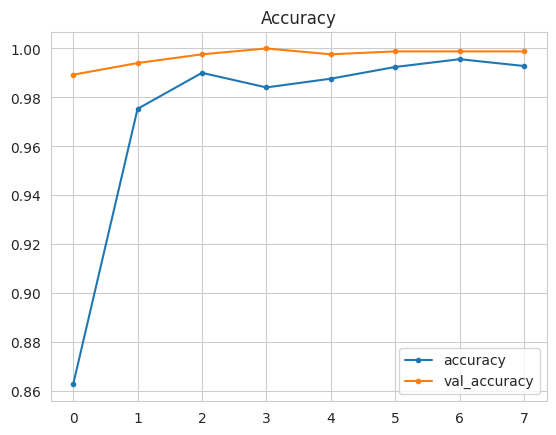

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

Evaluate Model

In [32]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model100.h5')

Evaluate on Test Set

In [33]:
evaluation = model.evaluate(test_set)

85/85 [==============================] - 3s 34ms/step - loss: 0.0170 - accuracy: 0.9976


Save evaluation

In [34]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

Predict on individual images

Image shape: (100, 100), Image mode: RGB


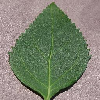

In [48]:
from tensorflow.keras.preprocessing import image

pointer = 232 
label = labels[0] # select 0 for Healthy or 1 for Mildew Infected

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=(100, 100), color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [49]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


In [50]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 16ms/step
0.9999999900607568
healthy
